In [3]:
import numpy as np
import keras
from keras.layers import *
from keras.models import Sequential
from tqdm import tqdm
from glob import glob
import keras.backend as K
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.layers.advanced_activations import LeakyReLU
from sklearn.model_selection import train_test_split
from scipy.io import loadmat
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.misc.pilutil import imresize

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
filenames = np.array(glob('img_align_celeba/*.jpg'))

<function matplotlib.pyplot.show(*args, **kw)>

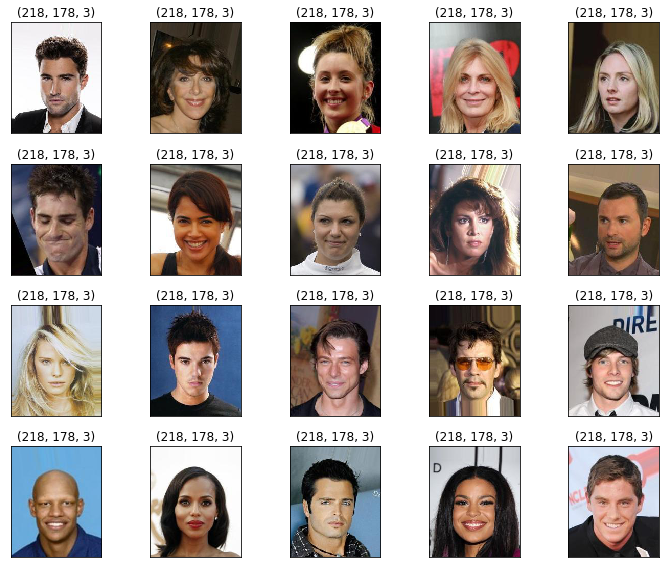

In [5]:
plt.figure(figsize = (10, 8))
for i in range(20):
    img = plt.imread(filenames[i])
    plt.subplot(4, 5, i+1)
    plt.imshow(img)
    plt.title(img.shape)
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show

In [6]:
X_train, X_test = train_test_split(filenames, test_size = 1000)

In [8]:
def load_img(filenames, size = (32, 32)):
    img = plt.imread(filenames)
    rows, cols = img.shape[:2]
    crop_r, crop_c = 150, 150
    start_row, start_col = (rows - crop_r) // 2, (cols - crop_c) // 2
    end_row, end_col = rows - start_row, cols - start_col
    img = img[start_row:end_row, start_col:end_col, :]
    img = imresize(img, size)
    return img
    

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:8: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


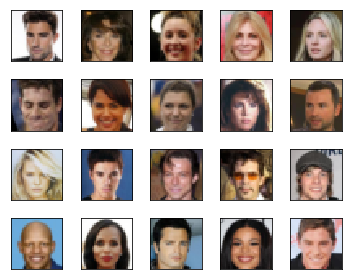

In [9]:
plt.figure(figsize = (5, 4))
for i in range(20):
    img = load_img(filenames[i])
    plt.subplot(4, 5, i+1)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

In [21]:
def preprocess(x):
    return (x/255)*2 - 1        #tanh activation functio

def deprocess(x):
    return np.uint8((x+1)/2*255)


In [11]:
def get_generator(input_size, leaky_alpha, init_stddev):
    model = Sequential()
    model.add(Dense(4*4*512, input_shape = (input_size, ), kernel_initializer = RandomNormal(stddev = init_stddev)))
    model.add(Reshape(target_shape = (4, 4, 512)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha = leaky_alpha))
    model.add(Conv2DTranspose(256, kernel_size=5, strides=2, padding='same', kernel_initializer=RandomNormal(stddev=init_stddev)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=leaky_alpha))
    model.add(Conv2DTranspose(128, kernel_size=5, strides=2, padding='same', kernel_initializer=RandomNormal(stddev=init_stddev)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=leaky_alpha))
    model.add(Conv2DTranspose(3, kernel_size=5, strides=2, padding='same', kernel_initializer=RandomNormal(stddev=init_stddev)))
    model.add(Activation('tanh'))
    return model

In [12]:
def get_discriminator(leaky_alpha, init_stddev):
    model = Sequential()
    model.add(Conv2D(64, kernel_size=5, strides=2, padding='same', kernel_initializer=RandomNormal(stddev=init_stddev), input_shape=(32, 32, 3)))
    model.add(LeakyReLU(alpha=leaky_alpha))
    model.add( Conv2D(128, kernel_size=5, strides=2, padding='same', kernel_initializer=RandomNormal(stddev=init_stddev)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=leaky_alpha))
    model.add( Conv2D(256, kernel_size=5, strides=2, padding='same', kernel_initializer=RandomNormal(stddev=init_stddev)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=leaky_alpha))
    model.add(Flatten())
    model.add(Dense(1, kernel_initializer=RandomNormal(stddev=init_stddev)))
    model.add(Activation('sigmoid'))
    return model
    

In [13]:
def get_DCGAN(sample_size, g_learning_rate, g_beta_1, d_learning_rate, d_beta_1, leaky_alpha, init_std):
    generator = get_generator(sample_size, leaky_alpha, init_std)
    discriminator = get_discriminator(leaky_alpha, init_std)
    discriminator.compile(optimizer = Adam(lr = d_learning_rate, beta_1 = d_beta_1), loss = 'binary_crossentropy')
    gan = Sequential([generator, discriminator])
    gan.compile(optimizer=Adam(lr=g_learning_rate, beta_1=g_beta_1), loss='binary_crossentropy')
    return gan, generator, discriminator


In [14]:
def make_latent_samples(n_samples, sample_size):
    return np.random.normal(loc=0, scale=1, size=(n_samples, sample_size))

def make_trainable(model, trainable):
    for layer in model.layers:
        layer.trainable = trainable
        
def make_labels(size):
    return np.ones([size, 1]), np.zeros([size, 1])

def show_losses(losses):
    losses = np.array(losses)
    fig, ax = plt.subplots()
    plt.plot(losses.T[0], label='Discriminator')
    plt.plot(losses.T[1], label='Generator')
    plt.title("Validation Losses")
    plt.legend()
    plt.show()

def show_images(generated_images):
    n_images = len(generated_images)
    cols = 10
    rows = n_images//cols
    plt.figure(figsize=(10, 8))
    for i in range(n_images):
        img = deprocess(generated_images[i])
        ax = plt.subplot(rows, cols, i+1)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()
    plt.show()    

In [24]:
def train(g_learning_rate, g_beta_1, d_learning_rate, d_beta_1, leaky_alpha, init_std, smooth = 0.1, sample_size = 100, epochs = 3, batch_size = 128, eval_size = 16, show_details = True):
    y_train_real, y_train_fake = make_labels(batch_size)
    y_eval_real, y_eval_fake = make_labels(eval_size)
    
    gan, generator, discriminator = get_DCGAN(sample_size, g_learning_rate, g_beta_1, d_learning_rate, d_beta_1, leaky_alpha, init_std)
    
    losses = []
    
    for e in range(epochs):
        for i in tqdm(range(len(X_train) // batch_size)):
            X_batch = X_train[i*batch_size:(i+1)*batch_size]
            X_batch_real = np.array([preprocess(load_img(filename)) for filename in X_batch])

            latent_samples = make_latent_samples(batch_size, sample_size)
            X_batch_fake = generator.predict_on_batch(latent_samples)
            
            make_trainable(discriminator, True)        
            discriminator.train_on_batch(X_batch_real, y_train_real * (1 - smooth))
            discriminator.train_on_batch(X_batch_fake, y_train_fake)
            
            make_trainable(discriminator, False)
            gan.train_on_batch(latent_samples, y_train_real)
        
        X_eval = X_test[np.random.choice(len(X_test), eval_size, replace=False)]
        X_eval_real = np.array([preprocess(load_img(filename)) for filename in X_eval])
        
        latent_samples = make_latent_samples(eval_size, sample_size)
        X_eval_fake = generator.predict_on_batch(latent_samples)
        d_loss  = discriminator.test_on_batch(X_eval_real, y_eval_real)
        d_loss += discriminator.test_on_batch(X_eval_fake, y_eval_fake)
        g_loss  = gan.test_on_batch(latent_samples, y_eval_real)
        
        losses.append((d_loss, g_loss))
        print("Epoch: {:>3}/{} Discriminator Loss: {:>6.4f} Generator Loss: {:>6.4f}".format(
            e+1, epochs, d_loss, g_loss))    
        show_images(X_eval_fake[:10])
    
    # show the result
    if show_details:
        show_losses(losses)
        show_images(generator.predict(make_latent_samples(80, sample_size)))    
    return generator

  0%|          | 0/1574 [00:00<?, ?it/s]/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:8: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/training.py:478: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
100%|██████████| 1574/1574 [15:05<00:00,  1.74it/s]


Epoch:   1/3 Discriminator Loss: 1.0478 Generator Loss: 2.0122


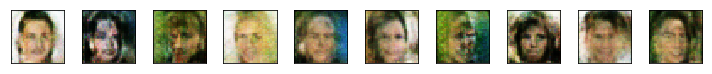

100%|██████████| 1574/1574 [14:59<00:00,  1.75it/s]


Epoch:   2/3 Discriminator Loss: 1.4309 Generator Loss: 2.8568


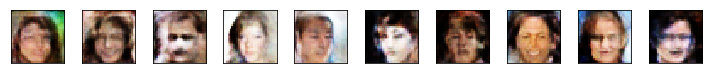

100%|██████████| 1574/1574 [14:59<00:00,  1.75it/s]


Epoch:   3/3 Discriminator Loss: 1.0732 Generator Loss: 0.9011


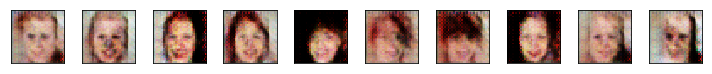

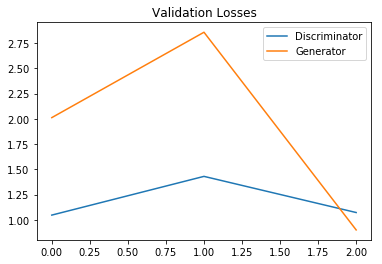

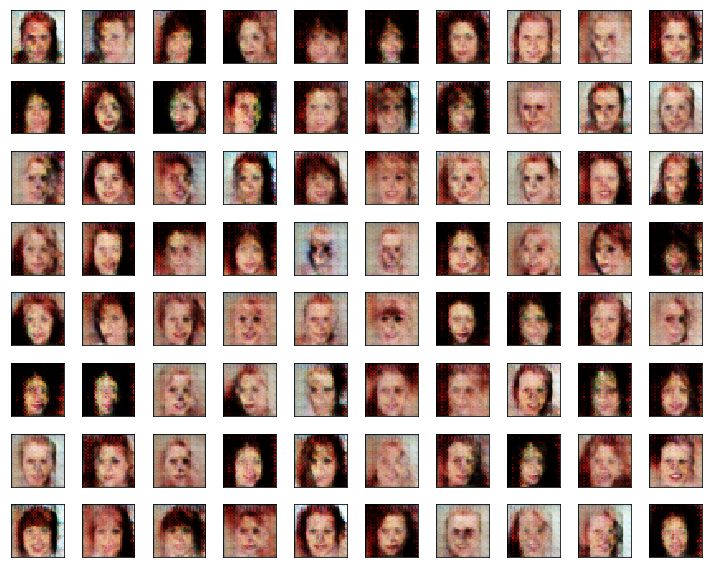

In [25]:
train(g_learning_rate=0.0001, 
      g_beta_1=0.5, 
      d_learning_rate=0.001, 
      d_beta_1=0.5, 
      leaky_alpha=0.2, 
      init_std=0.02);